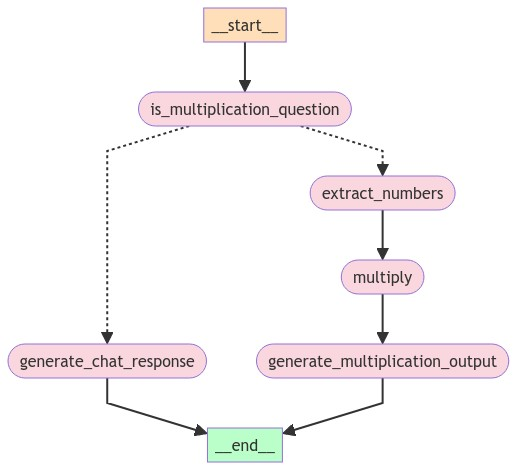

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List

from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage, AIMessage, SystemMessage
from typing import Literal
from IPython.display import Image, display

class State(TypedDict):
    messages: List
    numbers: list
    result: int
    is_multiplication: bool

graph = StateGraph(State)

def is_multiplication_question(state):
    llm = Ollama(model='llama3')
    prompt = PromptTemplate(
        input_variables=["input"],
        template="""
        Determine if the following input is a question asking to multiply two numbers. 
        Respond with 'Yes' if it is a multiplication question, and 'No' otherwise.

        Input: {input}
        """
    )
    input_message = state['messages'][-1].content
    response = llm.predict(prompt.format(input=input_message)).strip().lower()
    state['messages'].append(AIMessage(content=f"Checking if the input '{input_message}' is a multiplication question. Result: {response}"))
    return {'is_multiplication': response == 'yes'}

def extract_numbers(state):
    llm = Ollama(model='llama3')
    prompt = PromptTemplate(
        input_variables=["input"],
        template="""
        Extract the two numbers from the following input that need to be multiplied. 
        Return them as a comma separated list of integers.

        Input: {input}
        
        Respond only with a comma separated list of integers.
        """
    )
    input_message = state['messages'][-1].content
    numbers_str = llm.predict(prompt.format(input=input_message)).strip()
    numbers = [int(x.strip()) for x in numbers_str.split(',')]
    state['messages'].append(AIMessage(content=f"Extracted numbers from the input: {numbers}"))
    return {'numbers': numbers}

def multiply(state):
    result = state['numbers'][0] * state['numbers'][1]
    state['messages'].append(AIMessage(content=f"Multiplied {state['numbers'][0]} and {state['numbers'][1]} to get {result}"))
    return {'result': result}

def generate_multiplication_output(state):
    llm = Ollama(model='llama3')
    prompt = PromptTemplate(
        input_variables=["input", "result"],
        template="""
        You are a messenger only, tasked to give the user an answer.  Do not interpret the answer, just provide it to the user.  
        The user asked {input}.  The answer given is {result}
        """
    )
    input_message = state['messages'][-1].content
    output = llm.predict(prompt.format(input=input_message, result=state['result']))
    state['messages'].append(AIMessage(content=output))
    return {'messages': state['messages']}

def generate_chat_response(state):
    llm = Ollama(model='llama3')
    prompt = PromptTemplate(
        input_variables=["input"],
        template="""
        Respond to the following chat input naturally: {input}
        """
    )
    input_message = state['messages'][-1].content
    output = llm.predict(prompt.format(input=input_message))
    state['messages'].append(AIMessage(content=output))
    return {'messages': state['messages']}

def router(state) -> Literal["extract_numbers", "generate_chat_response"]:
    if state['is_multiplication']:
        return "extract_numbers"
    else:
        return "generate_chat_response"

graph.add_node("is_multiplication_question", is_multiplication_question)
graph.add_node("extract_numbers", extract_numbers)
graph.add_node("multiply", multiply)
graph.add_node("generate_multiplication_output", generate_multiplication_output)
graph.add_node("generate_chat_response", generate_chat_response)

graph.add_conditional_edges("is_multiplication_question", router)
graph.add_edge("extract_numbers", "multiply")
graph.add_edge("multiply", "generate_multiplication_output")
graph.add_edge("generate_multiplication_output", END)
graph.add_edge("generate_chat_response", END)

graph.set_entry_point("is_multiplication_question")

runnable = graph.compile()

display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))

In [3]:
inputs = {'messages': [HumanMessage("What is ten * one hundres")]}
#inputs = {'messages': [HumanMessage("Hi how are you")]}

seen_messages = set()

for event in runnable.stream(inputs, stream_mode="values"):
    for message in event['messages']:
        if isinstance(message, HumanMessage):
            message_id = id(message)
            if message_id not in seen_messages:
                print(f"Human: {message.content}")
                seen_messages.add(message_id)
        elif isinstance(message, AIMessage):
            message_id = id(message)
            if message_id not in seen_messages:
                print(f"Assistant: {message.content}")
                seen_messages.add(message_id)

Human: What is ten * one hundres


/Users/corymills/Develop/llm-actions/.venv/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.predict` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Assistant: Checking if the input 'What is ten * one hundres' is a multiplication question. Result: yes
Assistant: Extracted numbers from the input: [10, 100]
Assistant: Multiplied 10 and 100 to get 1000
Assistant: You are correct that the result of multiplying 10 and 100 is indeed:

10 × 100 = 1000
